<a href="https://colab.research.google.com/github/shobs315/DeepLearning/blob/main/CNN_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Convolutional Neural Networks


In [ ]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import cv2
import numpy as np
import requests
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Convolution - Filter


Goal:
- Re-implement filters from OpenCV libarary (cv2) using [`torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding="same")`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html).


- kernel size, kH, kW; blur strength, sigmaH, sigmaW


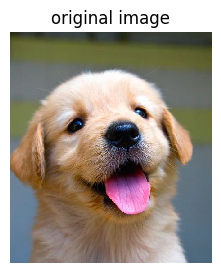

(516, 449, 3)


In [ ]:
def error(x, y):
  if type(x) is torch.Tensor:
    x = x.detach().cpu().numpy()
  if type(y) is torch.Tensor:
      y = y.detach().cpu().numpy()
  return float(np.abs(x - y).max().item())

def display(images, titles=""):
  if type(images) is not list:
    images = [images]
    titles = [titles]
  num = len(images)
  assert len(titles) == num

  plt.figure(figsize=(3*num, 3*num), dpi=100)
  for i in range(num):
    title = titles[i]
    image = images[i]
    plt.subplot(1, num, i+1)
    clip = np.clip(image, 0, 255).astype(np.uint8)
    plt.imshow(clip)
    if len(title) > 0:
      plt.title(title)
    plt.axis('off')
  plt.show()

# read image from url
url = "https://drive.google.com/uc?export=view&id=1IW5HONi0iZoA1gvux_MGXJdnrO8LpJrB"
response = requests.get(url)
rgb_img = Image.open(BytesIO(response.content))
img = np.array(rgb_img).astype("float")
display(img, titles="original image")
print(img.shape)  # H×W×C

### Laplacian Filter
- For edge detection
- A discrete approximation of second-order derivative

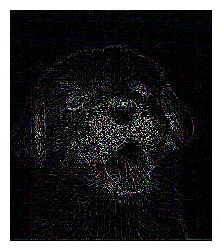

In [ ]:
edge = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
display(edge * 5)

 **Implementing 3×3 Laplacian filter**: equivalent to cv2.Laplacian with ksize=1
- https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gad78703e4c8fe703d479c1860d76429e6
- using `F.conv2d`

In [ ]:
def laplacian_filter(img):
  """
  img: np.array of image H × W × C, float
  return: np.array of filterd image H × W × C, float
  """
  filtered = None

  kernel = torch.Tensor([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ]).unsqueeze(0).unsqueeze(0).float() #[1, 1, 3, 3] out, in/groups, kh, kw

  img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(1).float()  # (c, 1, h, w)
  #print(img_tensor.shape)
  filtered_tensor = F.conv2d(img_tensor, kernel, padding='same', bias = None, stride = 1)
  filtered_img = filtered_tensor.squeeze().numpy().transpose((1, 2, 0))
  filtered = np.clip(filtered_img, 0, 255)
  return filtered

In [ ]:
def check_laplacian_filter(img):
  x = cv2.Laplacian(img.astype(np.uint8), ddepth=24, ksize=1, borderType=cv2.BORDER_CONSTANT)
  y = laplacian_filter(img)
  err = error(x,y)
  assert err < 1e-5, f"large error"
  print("pass")

check_laplacian_filter(img)

pass


### Gaussian Blur

https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

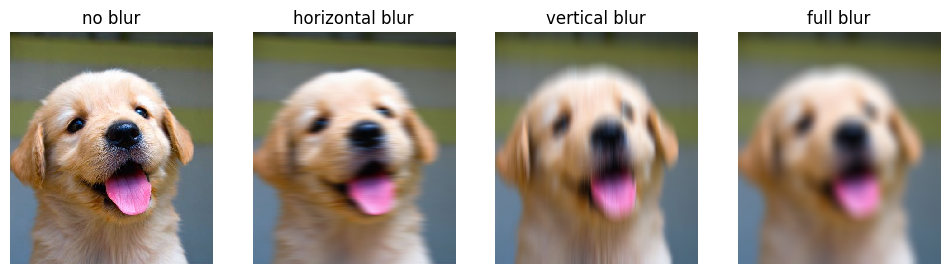

In [ ]:
# ksize=(kW, kH)
# if kernel size is 1, no blur in that direction, regardless of sigma
# blur strength increases with kernel size and sigma
no_blur = cv2.GaussianBlur(img, ksize=(1,1), sigmaX=10, sigmaY=20)
h_blur = cv2.GaussianBlur(img, ksize=(31,1), sigmaX=10, sigmaY=20)
v_blur = cv2.GaussianBlur(img, ksize=(1,41), sigmaX=10, sigmaY=20)
full_blur = cv2.GaussianBlur(img, ksize=(31,41), sigmaX=10, sigmaY=20)
display([no_blur, h_blur, v_blur, full_blur], titles=["no blur", "horizontal blur", "vertical blur", "full blur"])

Gaussian Blur is a [separable filter](https://en.wikipedia.org/wiki/Separable_filter), and we will use this property for implementation
- Definition: A 2d filter matrix $\mathbf{H}\in \mathbb{R}^{m\times n}$ is separable iff  it can be factorized as the outer product of two vectors, i.e.,  $\mathbf{H} = \mathbf{y} \mathbf{x}^\top$, where $\mathbf{y}\in\mathbb{R}^m$ and $\mathbf{x}\in\mathbb{R}^n$
- $\mathbf{H}$ is separable iff it has rank 1
- Example: box filter, Gaussian filter, Sobel, Prewitt
- Three equivalent implementations (pseudocode):
```python
# a. 2D convolution
Z1 = conv2d(X, H)
# b. composite 1D convolution, vertical first
Z_y = conv1d(X, y)
Z2 = conv1d(Z_y, x)
# c. composite 1D convolution, horizontal first
Z_x = conv1d(X, x)
Z3 = conv1d(Z_x, y)
```
- Implement separable filter as composite of 1d convolutions is more [efficient](https://en.wikipedia.org/wiki/Separable_filter) than as a single 2d convolution (especially with relatively large kernel size)


**Implement 1d filter first**


In [ ]:
def gaussian_filter_1d(img, k, sigma, horizontal=True):
  """
  img: np.array of image H × W × C, float
  k: 1d kernel size, positive odd int
  sigma: Gaussian standard deviation, positive float
  horizontal: whether it's horizontal or vertical filter; the function should work for both cases
  return: np.array of filterd image H × W × C, float
  """
  assert k > 0 and k % 2 == 1
  filtered = None

  H, W, C = img.shape
  kernel = cv2.getGaussianKernel(k, sigma)
  if horizontal:
    kernel = np.transpose(kernel, (1,0))  # horizontal
    img = np.transpose(img, (2, 0, 1)) # c h w
    img = img.reshape(C * H, 1, W) # c * h, 1, w
  else:
    kernel = kernel.reshape(1,-1) #vertical
    img = np.transpose(img,(2, 1, 0)) # c w h
    img = img.reshape(C * W, 1, H) #c * w, 1, h
  img = torch.from_numpy(img)
  conv_weight = torch.tensor(kernel).unsqueeze(0) # 1, 1, kW/kH

  #Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding,
  filtered = F.conv1d(img, conv_weight, padding = 'same', stride = 1, bias = None) #  c * h/w, 1, w

  if horizontal:
    filtered = filtered.reshape(C, H, W)
    filtered = filtered.permute(1, 2, 0)
  else:
    filtered = filtered.reshape(C, W, H)
    filtered = filtered.permute(2, 1, 0)
  filtered = filtered.numpy()

  return filtered

In [ ]:
def check_gaussian_filter_1d(img, kW, kH, sigmaW=1, sigmaH=1):
  if kH == 1:
    actual = gaussian_filter_1d(img, kW, sigmaW, horizontal=True)
  elif kW == 1:
    actual = gaussian_filter_1d(img, kH, sigmaH, horizontal=False)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-5, f"large error {err: .5f}"
  print(f"pass")

In [ ]:
check_gaussian_filter_1d(img, kW=1, kH=1)  # no blur

pass


In [ ]:
check_gaussian_filter_1d(img, kW=13, kH=1, sigmaW=10) # horizontal blur

pass


In [ ]:
check_gaussian_filter_1d(img, kW=1, kH=17, sigmaH=21) # vertical blur

pass


**Implementing 2d gaussian filter**
- using the composite of `gaussian_filter_1d` implemented above


In [ ]:
def gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  """
  img: np.array of image H × W × C
  kW: horizontal kernel size, positive odd int
  kH: vertical kernel size, positive odd int
  sigmaW: horizontal sigma, positive float
  sigmaH: vertical sigma, positive float
  return: np.array of filterd image H × W × C, float
  """
  assert kW > 0 and kW % 2 == 1
  assert kH > 0 and kH % 2 == 1
  filtered = None

  img = gaussian_filter_1d(img, kW, sigmaW, horizontal=True)
  filtered = gaussian_filter_1d(img, kH, sigmaH, horizontal=False)

  return filtered

In [ ]:
def check_gaussian_filter_2d(img, kW, kH, sigmaW=1, sigmaH=1):
  actual = gaussian_filter_2d(img, kW, kH, sigmaW, sigmaH)
  expected = cv2.GaussianBlur(img, ksize=(kW,kH), sigmaX=sigmaW, sigmaY=sigmaH, borderType=cv2.BORDER_CONSTANT)
  assert actual.shape == img.shape
  err = error(actual, expected)
  assert err < 1e-4, f"large error {err: .4f}"
  print(f"pass")

In [ ]:
check_gaussian_filter_2d(img, kW=1, kH=1, sigmaW=50, sigmaH=29)  # no blur

pass


In [ ]:
check_gaussian_filter_2d(img, kW=1, kH=13, sigmaW=59, sigmaH=67) # horizontal blur

pass


In [ ]:
check_gaussian_filter_2d(img, kW=17, kH=1, sigmaW=59, sigmaH=67) # vertical blur

pass


In [ ]:
check_gaussian_filter_2d(img, kW=31, kH=41, sigmaW=59, sigmaH=67) # full blur

pass


In [ ]:
check_gaussian_filter_2d(img, kW=21, kH=11, sigmaW=45, sigmaH=30) # full blur

pass


## Convolution - Forward Pass (20 points)

Let us now implement the forward pass of 2D convolution and get a better understanding of the operations it performs. We will be replicating the functionality of PyTorch's built-in 2D convolution: [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) and [`F.conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html?highlight=conv2d#torch.nn.functional.conv2d). Please refer to the documentation for more details of the input arguments and return values. It is acceptable to use nested loops here, but you may also develop a vectorized implementation.

In [ ]:
def conv2d(input, weight, bias=None, stride=1, padding=0):
  """
  Apply 2D convolution over a batch of input tensors.

  Input arguments and return value are the same as those of F.conv2d(),
  except that we don't care about `dilation` and `groups` here.
  Also, `padding_mode` is `zeros`.
  """
  output = None

  batch_size, in_channels, in_height, in_width = input.size()
  out_channels, _, ks1, ks2 = weight.size()

  if isinstance(padding, int):
    padding = (padding, padding)
  #print(padding)

  if isinstance(stride,int):
    stride = (stride,stride)

  kernel_size = (ks1, ks2)

  # compute output dimensions
  out_height = int((in_height + 2 * padding[0] - kernel_size[0]) / stride[0] + 1)
  out_width = int((in_width + 2 * padding[1] - kernel_size[1]) / stride[1] + 1)
  #print(out_height, out_width)
  # pad input tensor
  input = F.pad(input, [padding[1], padding[1], padding[0], padding[0]], 'constant', 0)
  #print(input.shape)

  output = torch.zeros(batch_size, out_channels, out_height, out_width, dtype=input.dtype, device=input.device)

  # perform 2D convolution
  for b in range(batch_size):
      for c_out in range(out_channels):
          for c_in in range(in_channels):
              for i in range(0, in_height + 2 * padding[0] - kernel_size[0] + 1, stride[0]):
                  for j in range(0, in_width + 2 * padding[1] - kernel_size[1] + 1, stride[1]):
                      output[b, c_out, i // stride[0], j // stride[1]] += (
                          input[b, c_in, i:i+kernel_size[0], j:j+kernel_size[1]] *
                          weight[c_out, c_in, :, :]
                      ).sum()

          if bias is not None:
              output[b, c_out, :, :] += bias[c_out]
  #print('output shape: ', output.shape)
  return output

Using the following helper functions to check results:

In [ ]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [ ]:
def check_conv2d(batch_size, in_channels, in_height, in_width,
                 out_channels, kernel_size, stride=1, padding=0, use_bias=True):

  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)

  torch.manual_seed(0)
  input = torch.empty(batch_size, in_channels, in_height, in_width).normal_()
  weight = torch.empty(out_channels, in_channels, kernel_size[0], kernel_size[1]).normal_()
  if use_bias:
    bias = torch.empty(out_channels).normal_()
  else:
    bias = None

  actual = conv2d(input, weight, bias, stride, padding)
  expected = F.conv2d(input, weight, bias, stride, padding)
  assert actual.shape == expected.shape, 'incorrect shape'

  diff = max_diff(actual, expected)
  print('max_diff = %e' % diff)
  assert diff < 1e-3, 'incorrect result'

In [ ]:
# check `kernel_size`
check_conv2d(batch_size=8, in_channels=3, in_height=8, in_width=8,
             out_channels=8, kernel_size=3, stride=1, padding=0, use_bias=True)

max_diff = 3.814697e-06


In [ ]:
# check `stride`
check_conv2d(batch_size=4, in_channels=8, in_height=16, in_width=16,
             out_channels=3, kernel_size=5, stride=3, padding=0, use_bias=True)

max_diff = 1.144409e-05


In [ ]:
# check `padding`
check_conv2d(batch_size=1, in_channels=1, in_height=32, in_width=32,
             out_channels=4, kernel_size=8, stride=5, padding=3, use_bias=True)

max_diff = 5.722046e-06


In [ ]:
# check tuple arguments
check_conv2d(batch_size=16, in_channels=4, in_height=4, in_width=8,
             out_channels=1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1), use_bias=False)

max_diff = 9.536743e-07


In [ ]:
def max_rel_error(actual, expected):

  rel_error_top = (actual - expected).abs()
  rel_error_bot = actual.abs() + expected.abs() + 1e-7
  return (rel_error_top / rel_error_bot).max().item()

## CIFAR-10 Image Classification

Goal: **achieve at least 75% validation accuracy within 10-20 epochs**.
[tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

### Useful Examples
- **Network architecture**: [VGG](https://arxiv.org/abs/1409.1556) can be a good starting point. Keep in mind that this model is designed for ImageNet, which is much larger and have a different image resolution than CIFAR-10. You need to make some adaptations. For example, you may tweak the number of layers and number of channels. [ResNet](https://arxiv.org/abs/1512.03385) and [DenseNet](https://arxiv.org/abs/1608.06993) are also good architectures to try.
- **Batch normalization**: You can conveniently add batch normalization layers using [`nn.BatchNorm2d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm2d#torch.nn.BatchNorm2d). Does your model train faster with batch normalization?
- **Optimizer**: The [`torch.optim`](https://pytorch.org/docs/stable/optim.html) package implements many optimization algorithms that you can try, such as [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam), and [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop).
- **Regularization**: You may use weight decay or [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) to reduce overfitting.
- **Activation**: In addition to [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU), some recent papers also use [ELU](https://pytorch.org/docs/stable/generated/torch.nn.ELU.html?highlight=elu#torch.nn.ELU) and [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html?highlight=gelu#torch.nn.GELU). Can they improve your model's performance?
- **Pooling vs Strided Convolution**: Similar to pooling, strided convolution can reduce the spatial size of feature maps. However, strided convolution contains learnable parameters, which make the model more flexible. Does strided convolution lead to improved performance?
- **Flattening vs Global Average Pooling**: [GoogLeNet](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf), [ResNet](https://arxiv.org/abs/1512.03385), and [DenseNet](https://arxiv.org/abs/1608.06993) all use global average pooling followed by a single linear layer to produce the class probabilities from the last feature map. How does this compare to the traditional approach of flattening the last feature map and then having several fully connected layers?

### Data Preprocessing


In [ ]:
def get_data_loaders():
  """
  Normalize the data and split into (train 40K)/(val 10K)/(test 10K).

  Returns:
  - PyTorch DataLoaders that can automatically sample mini-batches.
  """
  loader_kwargs = {
    'batch_size': 100,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }

  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
  ])

  CIFAR10_train = CIFAR10(root='.', train=True, transform=transform, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, transform=transform, download=True)

  train_set, val_set = random_split(CIFAR10_train, [40000, 10000],
                                    generator=torch.Generator().manual_seed(0))

  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)
  test_loader = DataLoader(CIFAR10_test, **loader_kwargs)

  return train_loader, val_loader, test_loader

### Model



In [ ]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),

      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),

      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),

      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),

      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Flatten(),

      nn.Linear(256 * 2 * 2, 256),
      nn.BatchNorm1d(256),

      nn.ReLU(),
      nn.Dropout(0.5),

      nn.Linear(256, 10),
    )


  def forward(self, images, labels):
    """
    Compute the loss for a mini-batch of training samples.

    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B training images.
    - labels: A PyTorch tensor of shape (B,) containing the corresponding
      training labels; labels[i] = k means that images[i] has label k,
      where 0 <= k < 10.

    Returns:
    - loss: A PyTorch scalar giving the training loss of this mini-batch.
    """
    loss = None

    scores = self.model(images)
    loss = F.cross_entropy(scores, labels)

    return loss


  def predict(self, images):
    """
    Predict the labels for a mini-batch of images.

    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B images.

    Returns:
    - labels_pred: A PyTorch tensor of shape (B,) containing the predicted
      labels; labels_pred[i] = k means that k is the predicted label for
      images[i], where 0 <= k < 10.
    """
    labels_pred = None

    with torch.no_grad():
      scores = self.model(images)
      _, labels_pred = scores.max(1)

    return labels_pred

## Evaluation


In [ ]:
def eval_acc(model, data_loader):

  with torch.no_grad():
    model.eval()

    total = 0
    correct = 0

    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      labels_pred = model.predict(images)

      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()

    acc = 100 * correct / total

  return acc

## Training



In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch:   0 	 Loss: 2.550975 	 Val Acc: 9.980000
Train Epoch:   1 	 Loss: 0.955280 	 Val Acc: 61.610000
Train Epoch:   2 	 Loss: 0.842147 	 Val Acc: 63.850000
Train Epoch:   3 	 Loss: 0.641114 	 Val Acc: 69.810000
Train Epoch:   4 	 Loss: 0.663469 	 Val Acc: 71.320000
Train Epoch:   5 	 Loss: 0.446138 	 Val Acc: 74.840000
Train Epoch:   6 	 Loss: 0.477890 	 Val Acc: 75.910000


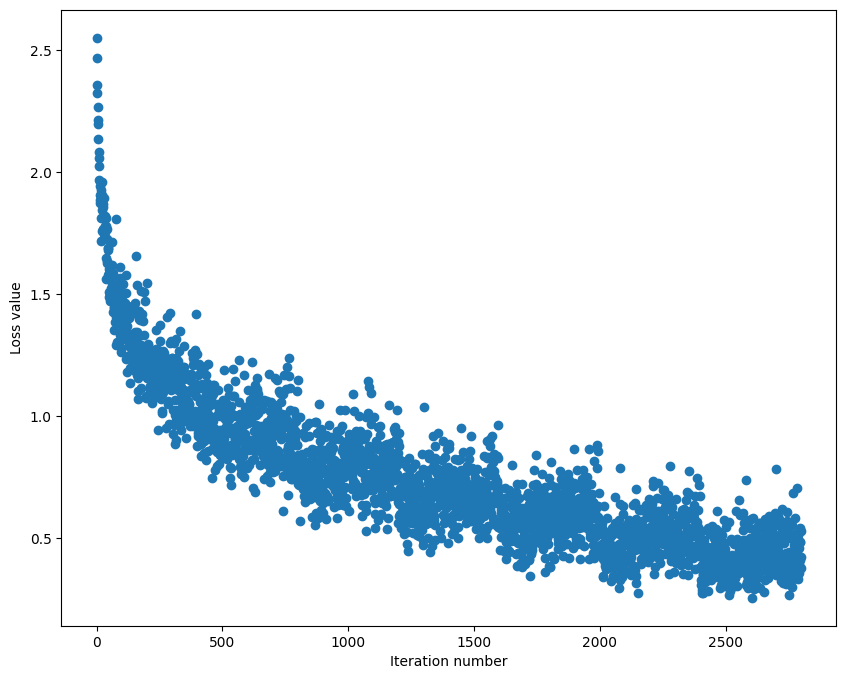

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders()

set_seed(0)
model = Net()
model = model.cuda()

num_epochs = 7
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)  # TODO: choose an optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
loss_history = []
best_model = None
best_acc = 0
for epoch in range(num_epochs):
  val_acc = eval_acc(model, val_loader)

  model.train()

  for batch, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    loss = model(images, labels)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      loss_history.append(loss.item())
      if batch == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
          epoch, loss.item(), val_acc))
  if val_acc > best_acc:
    best_acc = val_acc
    best_model = model
with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()
model = best_model

## Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
images = images.cuda()


images = images.cpu()
arr = np.array((images[11]))
arr = arr.transpose(1, 2, 0)
plt.imshow(arr)

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

Training Accuracy: 90.2325


In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)

Validation Accuracy: 76.05


In [ ]:
test_acc = eval_acc(model, test_loader)
print('Test Accuracy:', test_acc)

Test Accuracy: 76.13
